# Sentiment Classification of Movie Reviews using Transformers

## Data Pre-processing

In [5]:
import pandas as pd
from transformers import BertTokenizer


In [6]:
df = pd.read_csv(r"data\train.tsv", delimiter="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
df = df.drop_duplicates(subset=['SentenceId'], keep= 'first')

In [8]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


<Axes: >

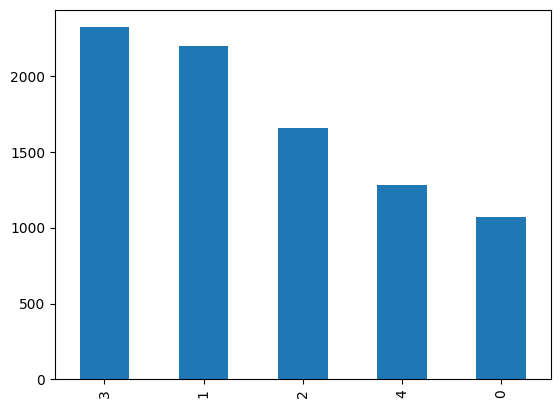

In [11]:
df['Sentiment'].value_counts().plot(kind='bar')

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


d:\NLP\nlp_env\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\abhishek.mazumdar\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
tokens = tokenizer(
    df['Phrase'].to_list(),
    max_length = 512,
    truncation = True, 
    padding = 'max_length',
    add_special_tokens = True,
    return_tensors = 'np'
)

In [18]:
len(tokens['input_ids'])

8529

In [19]:
df.shape

(8529, 4)

In [21]:
labels = df['Sentiment'].values

In [22]:
import numpy as np

In [23]:
empty_labels = np.zeros(shape=(df.shape[0], labels.max() + 1))
empty_labels.shape

(8529, 5)

In [25]:
empty_labels[np.arange(df.shape[0]), labels] = 1

In [28]:
onHotLabels = empty_labels
del empty_labels

In [29]:
onHotLabels

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Input Pipeline

In [31]:
Ids = tokens['input_ids']
Masks = tokens['attention_mask']

In [34]:
import tensorflow as tf

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((Ids, Masks, onHotLabels))
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Currently each sample of dataset is a tuple of (Ids, Masks, onHotLabels). The required input schema for model is (<input_data>, <output_data>). Hence, we need to convert ({Ids, Masks}, onHotLabels)    

In [41]:
def helper_map(input_ids, attention_mask, labels):
    return{'input_ids': input_ids, 'attention_mask': attention_mask}, labels

In [42]:
dataset = dataset.map(helper_map)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [49]:
train_size = (Ids.shape[0] / batch_size ) * 0.9
train_size

479.75625

In [51]:
train_data = dataset.take(round(train_size))
val_data = dataset.skip(round(train_size))

In [53]:
train_data.element_spec == val_data.element_spec

True

In [54]:
train_data.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [55]:
tf.data.experimental.save(train_data, 'train')
tf.data.experimental.save(val_data, 'val')


Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


## Training

In [3]:
import tensorflow as tf

In [1]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

bert.summary()

c:\Users\abhishek.mazumdar\.conda\envs\transformerEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 570/570 [00:00<00:00, 507kB/s]
Downloading: 100%|██████████| 527M/527M [00:40<00:00, 12.9MB/s]   
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the l

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [11]:
input_ids = tf.keras.layers.Input(shape=(512,), name = 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape= (512,), name='attention_mask', dtype='int32')

# access the embeddings at the final layer. Convert the 3D tensors to 2D
embeddings = bert.bert(input_ids, attention_mask= mask)[1]
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [12]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)
model.layers[2].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         787456      bert[1][1]                 

In [13]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

c:\Users\abhishek.mazumdar\.conda\envs\transformerEnv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
                'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

train_data = tf.data.experimental.load('train', element_spec = element_spec)
val_data = tf.data.experimental.load('val', element_spec = element_spec )

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3
)

Epoch 1/3
  2/480 [..............................] - ETA: 2:08:02 - loss: 1.5219 - accuracy: 0.0000e+00

In [ ]:
model.save('sentiment_model')